In [32]:
import xarray as xr
import cmocean
import matplotlib.pyplot as plt
from dask.diagnostics import ProgressBar
import numpy as np

In [34]:
ds = xr.open_mfdataset('../data/processed/regridded/CESM1.2_CAM5.*.mean.1x1.nc')
grid = xr.open_dataset('../data/processed/regridded/grid_1x1_depth.nc')

In [37]:
# Get integrated volume transport across each depth level
# convert vo to ms-1
wo = ds['wo']*1e-2
upwelling = wo.weighted(grid['area'].fillna(0)).sum('x')

In [40]:
with ProgressBar():
    upwellingnow = upwelling.mean('time').compute()

[########################################] | 100% Completed | 3.84 ss


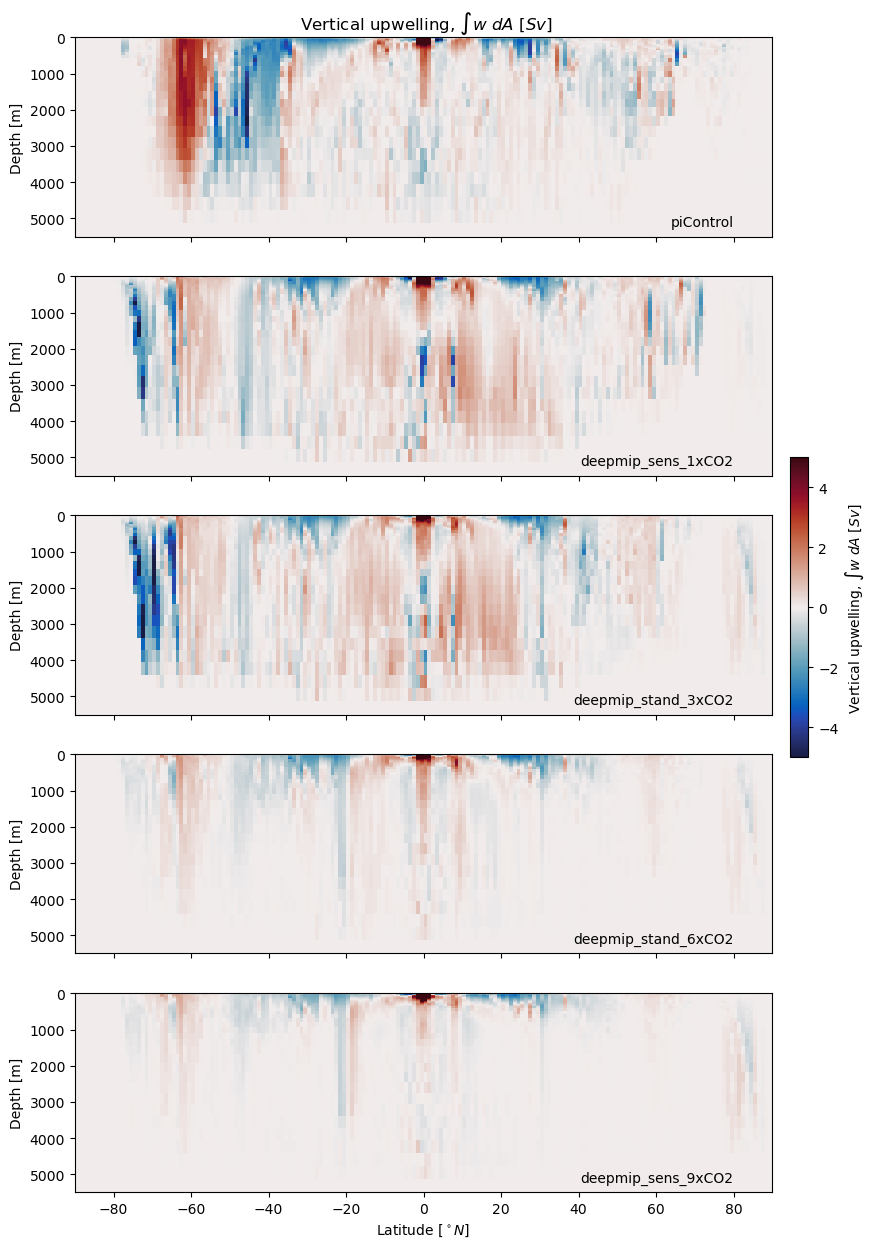

In [49]:
longname = 'Vertical upwelling, $\int w\ dA$ [$Sv$]'
experiments = ['piControl','deepmip_sens_1xCO2','deepmip_stand_3xCO2','deepmip_stand_6xCO2','deepmip_sens_9xCO2']

cmap = cmocean.cm.balance
cmap.set_bad(color='darkgrey')
clims = [-5,5]
ne = len(experiments)

fig,axarr = plt.subplots(figsize=(9,3*ne),nrows=ne)
for i,experiment in enumerate(experiments):
    axnow = axarr[i]
    da = (upwellingnow*1e-6).sel(experiment=experiment)
    # sigma2 = dssec.sel(experiment=experiment)['sigma2']
    # damask = np.ma.array(da,mask = np.isnan(da))
    im = axnow.pcolormesh(da['y'],da['z'],da,cmap=cmap)
    # cs = axnow.contour(da['y'],da['z'],sigma2,[30,32,34,36],colors='w',linestyles='--',linewidths=0.5)
    # axnow.clabel(cs)
    
    # add line at bathymetry
    # axnow.plot(da['y'],da['z'].isel(z=bathy1d),color='darkgrey')
    # label experiment
    axnow.text(80,5200,experiment,color='k',ha='right',fontweight=12)
    axnow.invert_yaxis()
    axnow.set_ylabel(r'Depth [m]')
    if i==ne-1:
        axnow.set_xlabel(r'Latitude [$^\circ N$]')
    else:
        axnow.set_xticklabels([])
    im.set_clim(clims)
    if i==0:
        axnow.set_title(r' '+longname)
axc = fig.add_axes([0.92,0.4,0.02,0.2])
cb = fig.colorbar(im,cax=axc)
cb.set_label(longname)

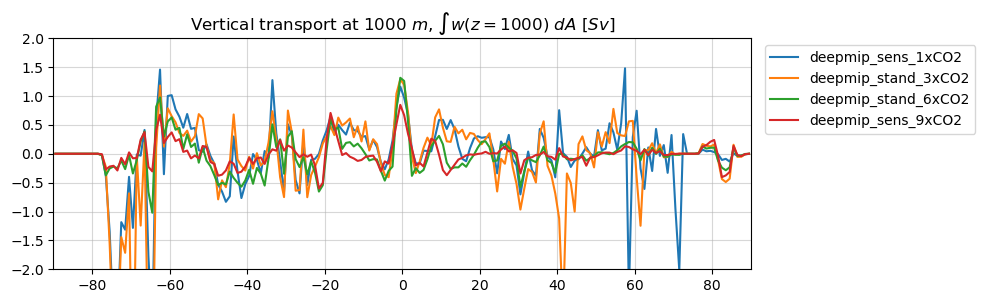

In [91]:
depth_target = 1000
longname = 'Vertical transport at $'+str(depth_target)+'\ m$, $\int w(z=1000)\ dA$ [$Sv$]'
experiments = ['deepmip_sens_1xCO2','deepmip_stand_3xCO2','deepmip_stand_6xCO2','deepmip_sens_9xCO2']

fig,ax = plt.subplots(figsize=(9,3))
for i,experiment in enumerate(experiments):
    da = upwellingnow.sel(experiment=experiment).sel(z=depth_target,method='nearest')
    ax.plot(da['y'],da*1e-6,label=experiment)
ax.legend(loc='upper left',bbox_to_anchor=(1.01,1))
ax.set_title(longname)
ax.set_xlim(-90,90)
ax.set_ylim(-2,2)
ax.grid(alpha=0.5)